# Compare Turbine Centerline Wakes for Unstable ABL

In [1]:
# Load the libraries                                                                                                                        

import numpy             as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import xarray as xr
#import argparse
import os
import pandas as pd
from netCDF4 import Dataset
import glob

import yaml as yaml
Loader=yaml.safe_load

# Make all plots inline 
%matplotlib inline

In [2]:
def loadyamldef(yamlfile, extradict={}):
    with open(yamlfile) as f:
        returndict = Loader(f)
    # Get the path to yamlfile
    dirpath = os.path.dirname(yamlfile)
    returndict['dirpath'] = dirpath
    # override any entries in the file
    for k,g in extradict.items():
        returndict[k] = g
    return returndict

def getitembyname(itemlist, name, namelabel='name'):
    for item in itemlist:
        if item[namelabel] == name: 
            return item
    return None

def appendcategory(turbdict, turbinegroup, categorylabel='categories'):
    """
    If there is a section of turbine categories in turbdict, create new turbine groups based on them
    """
    # First get all of the different categories
    allcategories = [k for k, g in turbdict[categorylabel].items()]
    for category in allcategories:
        turblist = []
        for t in turbdict[categorylabel][category]:
            newitem = getitembyname(turbdict[turbinegroup], t)
            # Should do error-checkign to make sure newitem is not None
            turblist.append(newitem)
        turbdict[turbinegroup+'_'+category] = turblist
    return
    
def getturblist(yamldef, group):
    """
    Return a list of all turbine names in group
    """
    # First check to make sure that the group exists:
    if group not in yamldef:
        return None 
    turbinegroup = yamldef[group]
    turblist = [x['name'] for x in turbinegroup]
    return turblist

def avgturbfiles(yamldef, group, turblist, wakelocations):
    """
    Average turbine wakes from a bunch of turbines
    """
    # First check to make sure that the group exists:
    if group not in yamldef:
        return None 
    turbinegroup = yamldef[group]
    skiprows = yamldef['skiprows'] if 'skiprows' in yamldef else 0
    avgwake = None
    Uh = None
    icount = 1
    for turb in turbinegroup:
        if turb['name'] in turblist:
            turbfile = os.path.join(yamldef['dirpath'], turb[wakelocations])
            dat = np.loadtxt(turbfile, skiprows=skiprows)
            if avgwake is None:
                avgwake  = dat
                Uh       = np.sqrt(dat[:,1]**2 + dat[:,2]**2)
            elif dat.shape == avgwake.shape:
                avgwake += dat
                Uh       += np.sqrt(dat[:,1]**2 + dat[:,2]**2)
                icount += 1
    avgwake /= float(icount)
    Uh /= float(icount)
    return avgwake, Uh

In [3]:
# Edit this list to include data
#           # YAML file,                                                dictionary with extra labels and stuff
datasets = [
    ['DATA_Summit_amrwind_bananasrun1/KingPlainsCenterlines.yaml', {'label':'AMR-Wind Summit', 'plotargs':{'color':'r'}}],
    ['DATA_Summit_amrwind_eastkp/KingPlainsCenterlines.yaml', {'label':'AMR-Wind Summit (East KP)', 'plotargs':{'color':'r', 'ls':'--'}}], 
    ['DATA_FLORIS_GCH_unstable/KingPlainsWakes.yaml',              {'label':'FLORIS GCH', 'plotargs':{'color':'g'}}], 
    ['DATA_SNL_naluwind_unstable_KPeast/KingPlainsCenterlines_NaluWind.yaml', {'label':'Nalu-Wind SNL', 'plotargs':{'color':'b'}}],
    
    #['DATA_eagle_WRFLESGAD_unstable/no_terrain/KingPlainsCenterlines.yaml', {'label':'WRF-LES-GAD (no terrain)', 'plotargs':{'color':'m'}}],
    #['DATA_eagle_WRFLESGAD_unstable/terrain/KingPlainsCenterlines.yaml', {'label':'WRF-LES-GAD (terrain)', 'plotargs':{'color':'m', 'ls':':'}}],
]

In [4]:
datadefs = []
for data in datasets:
    turbdict = loadyamldef(data[0], extradict=data[1])
    for group in ['turbinerun', 'precursorrun']:
        appendcategory(turbdict, group, categorylabel='categories')
    datadefs.append(turbdict)

Loading AMR-Wind Summit
Loading AMR-Wind Summit (East KP)
Loading FLORIS GCH
Loading Nalu-Wind SNL


Text(0.5, 1.0, 'King Plains turbine centerline, frontrow')

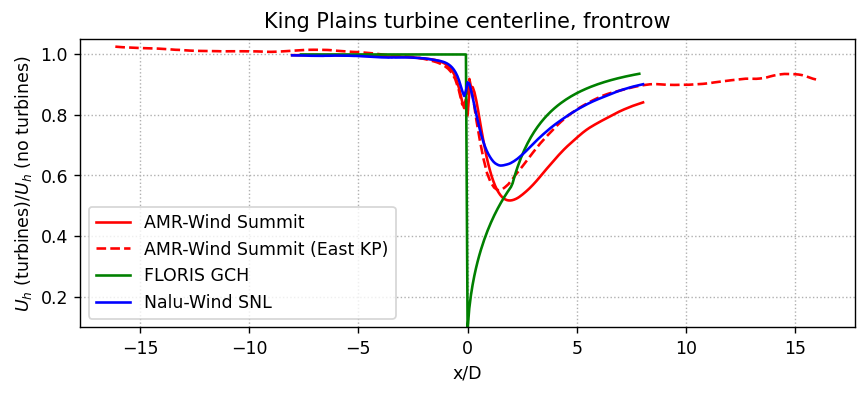

In [5]:
# Plot overall power
fig, ax = plt.subplots(1,1,figsize=(8,3), dpi=125)
for data in datadefs:
    print('Loading '+data['label'])
    plotargs = data['plotargs'] if 'plotargs' in data else {}
    plotargs['label'] = data['label']
    allturbs=getturblist(data, 'turbinerun')
    wturbs,  avg_Uh_wturbs  = avgturbfiles(data, 'turbinerun_frontrow',   allturbs, 'centerline')
    noturbs, avg_Uh_noturbs = avgturbfiles(data, 'precursorrun_frontrow', allturbs, 'centerline')
    x=wturbs[:,0]/data['rotorD']
    ax.plot(x, avg_Uh_wturbs/avg_Uh_noturbs, **plotargs)
    #ax.plot(x, avg_Uh_wturbs/avg_Uh_noturbs, label=data['label'])
    
ax.legend()
ax.grid(ls=':')
ax.set_xlabel('x/D')
ax.set_ylabel('$U_h$ (turbines)/$U_h$ (no turbines)')
ax.set_ylim([0.1, 1.05])
ax.set_title('King Plains turbine centerline, frontrow')

Loading AMR-Wind Summit
Loading AMR-Wind Summit (East KP)
Loading FLORIS GCH
Loading Nalu-Wind SNL


Text(0.5, 1.0, 'King Plains precursor centerline AVG velocity (frontrow turbines)')

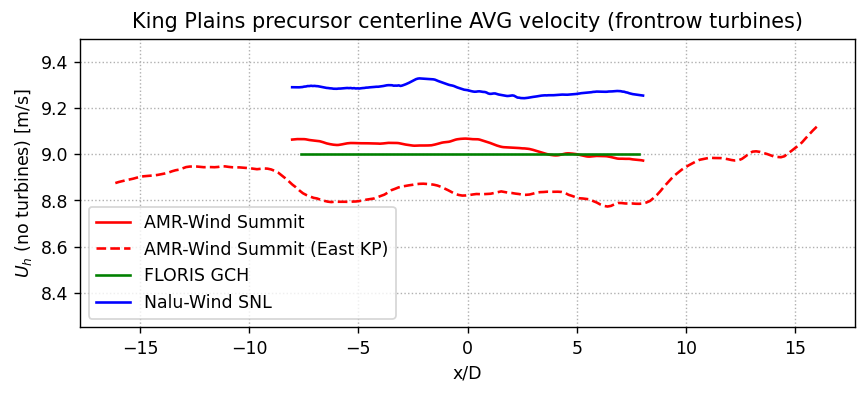

In [6]:
# Plot overall power
fig, ax = plt.subplots(1,1,figsize=(8,3), dpi=125)
for data in datadefs:
    print('Loading '+data['label'])
    plotargs = data['plotargs'] if 'plotargs' in data else {}
    plotargs['label'] = data['label']
    allturbs=getturblist(data, 'turbinerun')
    wturbs,  avg_Uh_wturbs  = avgturbfiles(data, 'turbinerun_frontrow',   allturbs, 'centerline')
    noturbs, avg_Uh_noturbs = avgturbfiles(data, 'precursorrun_frontrow', allturbs, 'centerline')
    x=wturbs[:,0]/data['rotorD']
    #ax.plot(x, noturbs[:,3], **plotargs)
    ax.plot(x, avg_Uh_noturbs, **plotargs)
    #ax.plot(x, avg_Uh_wturbs/avg_Uh_noturbs, label=data['label'])
    
ax.legend()
ax.grid(ls=':')
ax.set_xlabel('x/D')
ax.set_ylabel('$U_h$ (no turbines) [m/s]')
ax.set_ylim([8.25, 9.5])
ax.set_title('King Plains precursor centerline AVG velocity (frontrow turbines)')

Loading AMR-Wind Summit
Loading AMR-Wind Summit (East KP)
Loading FLORIS GCH
Loading Nalu-Wind SNL


Text(0.5, 1.0, 'King Plains precursor centerline AVG W (frontrow turbines)')

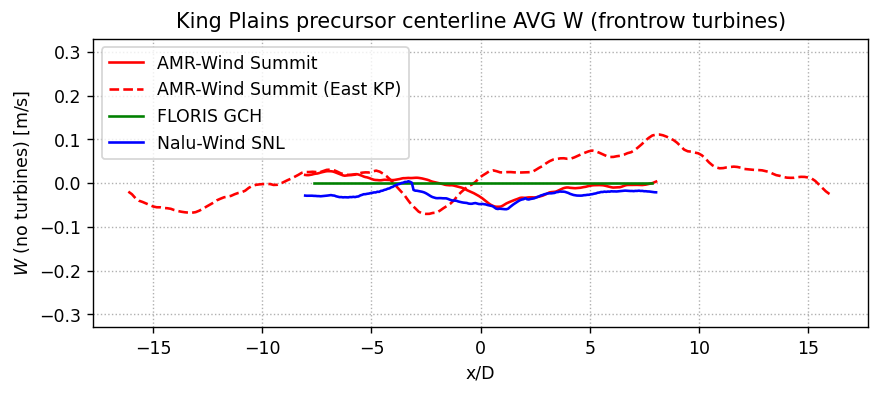

In [7]:
# Plot overall power
fig, ax = plt.subplots(1,1,figsize=(8,3), dpi=125)
for data in datadefs:
    print('Loading '+data['label'])
    plotargs = data['plotargs'] if 'plotargs' in data else {}
    plotargs['label'] = data['label']
    allturbs=getturblist(data, 'turbinerun')
    wturbs,  avg_Uh_wturbs  = avgturbfiles(data, 'turbinerun_frontrow',   allturbs, 'centerline')
    noturbs, avg_Uh_noturbs = avgturbfiles(data, 'precursorrun_frontrow', allturbs, 'centerline')
    x=wturbs[:,0]/data['rotorD']
    ax.plot(x, noturbs[:,3], **plotargs)
    #ax.plot(x, avg_Uh_noturbs, **plotargs)
    #ax.plot(x, avg_Uh_wturbs/avg_Uh_noturbs, label=data['label'])
    
ax.legend()
ax.grid(ls=':')
ax.set_xlabel('x/D')
ax.set_ylabel('$W$ (no turbines) [m/s]')
ax.set_ylim([-0.33, 0.33])
ax.set_title('King Plains precursor centerline AVG W (frontrow turbines)')

Loading AMR-Wind Summit
Loading AMR-Wind Summit (East KP)
Loading FLORIS GCH
Loading Nalu-Wind SNL


Text(0.5, 1.0, 'King Plains turbines centerline AVG W (frontrow turbines)')

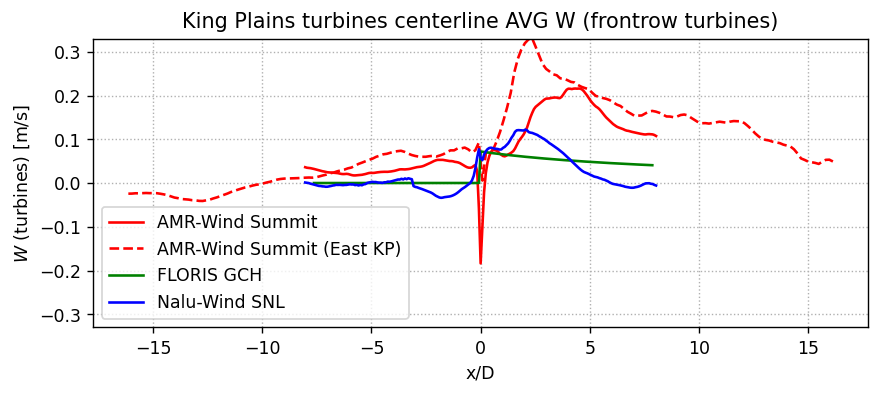

In [8]:
# Plot overall power
fig, ax = plt.subplots(1,1,figsize=(8,3), dpi=125)
for data in datadefs:
    print('Loading '+data['label'])
    plotargs = data['plotargs'] if 'plotargs' in data else {}
    plotargs['label'] = data['label']
    allturbs=getturblist(data, 'turbinerun')
    wturbs,  avg_Uh_wturbs  = avgturbfiles(data, 'turbinerun_frontrow',   allturbs, 'centerline')
    noturbs, avg_Uh_noturbs = avgturbfiles(data, 'precursorrun_frontrow', allturbs, 'centerline')
    x=wturbs[:,0]/data['rotorD']
    ax.plot(x, wturbs[:,3], **plotargs)
    #ax.plot(x, avg_Uh_noturbs, **plotargs)
    #ax.plot(x, avg_Uh_wturbs/avg_Uh_noturbs, label=data['label'])
    
ax.legend()
ax.grid(ls=':')
ax.set_xlabel('x/D')
ax.set_ylabel('$W$ (turbines) [m/s]')
ax.set_ylim([-0.33, 0.33])
ax.set_title('King Plains turbines centerline AVG W (frontrow turbines)')